# HW9: Forecasting Solar Cycles

Below is the notebook associated with HW\#9. You can run the notebook in two modes. If you have the `emcee` and `corner` packages installed on your machine, along with the data files, just keep the following variable set to `False`. If you are running it in a Google colab notebook, set it to `True` so that it will grab the packages and files. Remember that the Google colab environment will shutdown after ~1 hour of inactivity, so you'll need to keep interacting with it or else will lose the data.

A script version of this file will also be provided to you, but you cannot use this in a Google colab environment

In [10]:
COLAB = False

In [11]:
if COLAB:
    # Install emcee package
    !pip install emcee
    # Install corner package
    !pip install corner    
    # Grab sunspot data file
    !wget -O SN_m_tot_V2.0.txt https://raw.githubusercontent.com/mtlam/ASTP-720_F2020/master/HW9/SN_m_tot_V2.0.txt

In [12]:
import numpy as np
from matplotlib.pyplot import *
from matplotlib import rc
import emcee
import corner
%matplotlib inline

# Make more readable plots
rc('font',**{'size':14})
rc('xtick',**{'labelsize':16})
rc('ytick',**{'labelsize':16})
rc('axes',**{'labelsize':18,'titlesize':18})

## Define the (log-)priors

Here, the function should take a vector of parameters, `theta`, and return `0.0` if the it is in the prior range and `-np.inf` if it is outside. This is equivalent to a uniform prior over the parameters. You can, of course, define a different set of priors if you so choose!

In [13]:
def lnprior(theta):
    """
    Parameters
    ----------
    theta : np.ndarray
        Array of parameters.
        
    Returns
    -------
    Value of log-prior.    
    """
    for i in range(len(theta)):
        if -1 < theta[i] < 1:
            return 0.0
        else:
            return -np.inf

## Define the (log-)likelihood

In [26]:
def lnlike(theta, data):
    """
    Parameters
    ----------
    theta : np.ndarray
        Array of parameters.
    data : np.ndarray


    Returns
    -------
    Value of log-likelihood
    """
    #loglik = []
    mean = np.mean(data)
    factor = (1/np.sqrt(2*np.pi)) #factor infront of each function
    X2 = np.zeros(len(data)-132)
    
    #residual X^2 (eq 28 in 24notes)
    for x in np.arange(132, len(data)):
        X2[x-132] = (data[x]-mean)-theta[0]*(data[x-1]-mean)-theta[1]*(data[x-12]-mean)-theta[2]*(data[x-132]-mean) 
    
    #ln(sum of equations 31-33)
    loglik = -np.sum(((X2)**2)/2) - np.log(denominator)    
    return(loglik)

## Define total (log-)probability

No need to change this if the other two functions work as described.

In [27]:
def lnprob(theta, data):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, data)

## Set up the MCMC sampler here

In [28]:
# Number of walkers to search through parameter space
nwalkers = 10
# Number of iterations to run the sampler for
niter = 500
# Initial guess of parameters. For example, if you had a model like
# s(t) = a + bt + ct^2
# and your initial guesses for a, b, and c were 5, 3, and 8, respectively, then you would write
# pinit = np.array([5, 3, 8])
# Make sure the guesses are allowed inside your lnprior range!
pinit = np.array([0.5, 0.05, 0.05])
# Number of dimensions of parameter space
ndim = len(pinit)
# Perturbed set of initial guesses. Have your walkers all start out at
# *slightly* different starting values
p0 = [pinit + 1e-4*pinit*np.random.randn(ndim) for i in range(nwalkers)]

## Load the data, plot to show

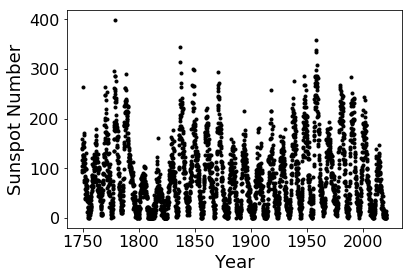

In [29]:
# Data: decimal year, sunspot number
decyear, ssn = np.loadtxt("SN_m_tot_V2.0.txt", unpack=True, usecols=(2, 3))
plot(decyear, ssn, 'k.')
xlabel('Year')
ylabel('Sunspot Number')
show()

## Run the sampler

In [30]:
# Number of CPU threads to use. Reduce if you are running on your own machine
# and don't want to use too many cores
nthreads = 4
# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(ssn,), threads=nthreads)
# Run the sampler. May take a while! You might consider changing the 
# number of iterations to a much smaller value when you're testing. Or use a 
# larger value when you're trying to get your final results out!
sampler.run_mcmc(p0, niter, progress=True)

100%|██████████| 500/500 [00:42<00:00, 12.13it/s]


State([[0.83985716 0.07130274 0.04648536]
 [0.84064862 0.07095831 0.0459016 ]
 [0.84120355 0.07057174 0.04479771]
 [0.84073859 0.07120471 0.04598071]
 [0.83996742 0.07146321 0.0461748 ]
 [0.83986264 0.07204448 0.04570238]
 [0.84089575 0.07085496 0.0459335 ]
 [0.84017167 0.07143486 0.04552362]
 [0.84102414 0.07101736 0.04580944]
 [0.84033537 0.07124386 0.04560674]], log_prob=[-1099627.57532987 -1099624.98963109 -1099632.56210442 -1099626.07199729
 -1099626.0503894  -1099627.00460676 -1099625.61555881 -1099625.68951112
 -1099626.23278415 -1099625.20094446], blobs=None, random_state=('MT19937', array([ 367019168, 3012978685,  546969012,  267154255,  982421684,
       1291795816, 1373644760,  308346001, 1888795347, 3190451451,
       1649361933, 1177764539, 3712158593,  898363799, 4293399203,
        162838565, 2284681655, 3607547895, 1714893063, 1275407808,
       2041392670,  999097955, 3736423417, 3975463047, 1125925722,
        147970336, 1330647627,   35182062,  105496738, 3105586734,

## Get the samples in the appropriate format, with a burn value

In [31]:
# Burn-in value = 1/4th the number of iterations. Feel free to change!
burn = int(0.25*niter)
# Reshape the chains for input to corner.corner()
samples = sampler.chain[:, burn:, :].reshape((-1, ndim))

## Make a corner plot

You should feel free to adjust the parameters to the `corner` function. You **should** also add labels, which should just be a list of the names of the parameters. So, if you had two parameters, $\phi_1$ and $\phi_2$, then you could write:

```
labels = [r"$\phi_1$", r"$\phi_2$"]
```

and that will make the appropriate label in LaTeX (if the distribution is installed correctly) for the two 1D posteriors of the corner plot.

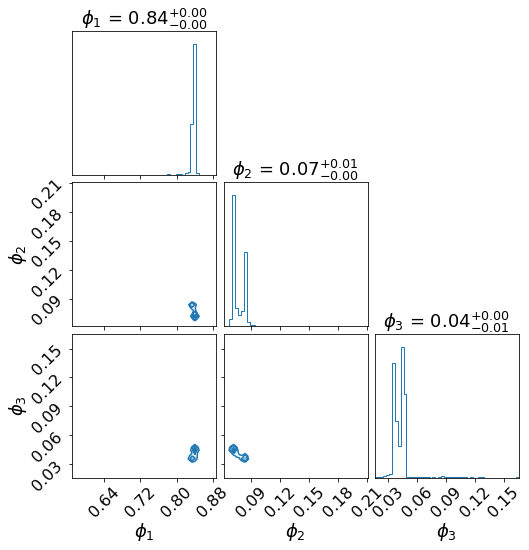

In [32]:
labels = [r"$\phi_1$", r"$\phi_2$", r"$\phi_3$"]

fig = corner.corner(samples, bins=50, color='C0', smooth=0.5, plot_datapoints=False, plot_density=True, \
                    plot_contours=True, fill_contour=False, show_titles=True, labels=labels)
#fig.savefig("corner.png")
show()

## Plot the Model

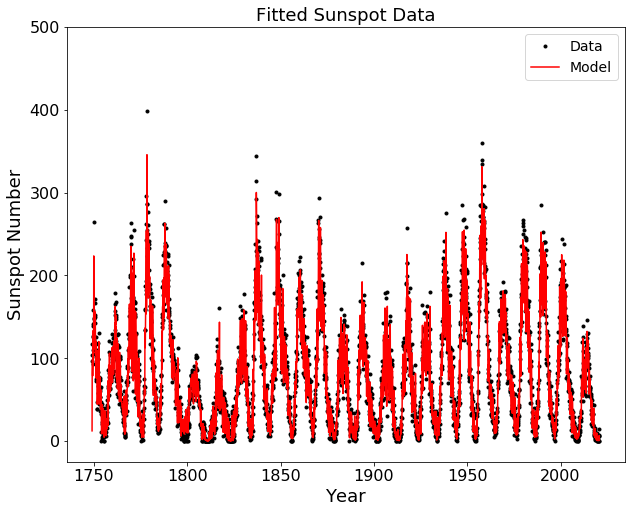

In [51]:
def model(theta, X):
    """
    model to fit the data
    ----
    theta = phi values
    X = x values that are read in from the dataset
    """
    model = np.zeros(len(X))
    for i in range(len(X)):
        model[i] = (theta[0]*X[i-1]) + (theta[1]*X[i-12]) + (theta[2]*X[i-132])
    return(model)

best_theta = np.mean(samples, axis=0)

figure(figsize=(10,8))
plot(decyear, ssn, 'k.', label = "Data")
plot(decyear, model(best_theta, ssn), 'r', label = "Model")
ylim([-25,500])
title('Fitted Sunspot Data')
xlabel('Year')
ylabel('Sunspot Number')
legend()
#savefig("FittedSunspot.png")
show()

## Residuals

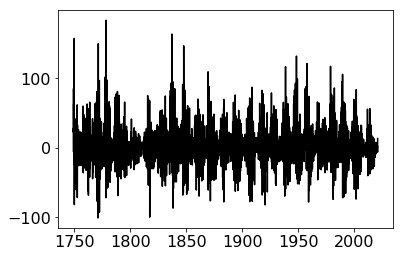

In [110]:
#Data = signal + noise => noise = Data - signal
Residual = ssn - model(best_theta, ssn)

plot(decyear, Residual, 'k')

#savefig('residuals.png')
show()

Text(0, 0.5, '$S_x(f)$')

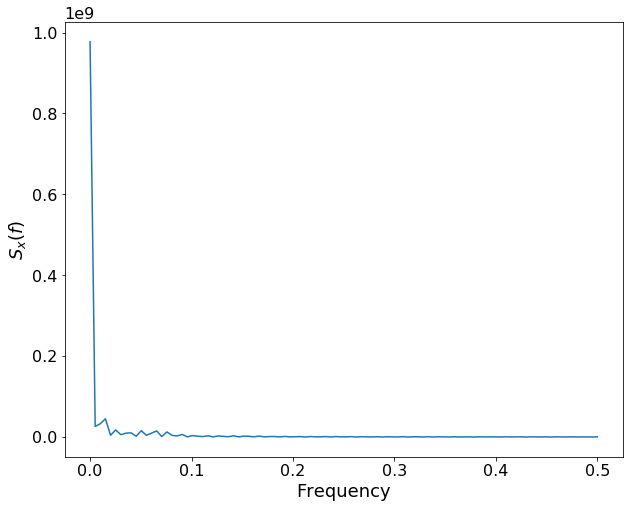

In [65]:
sig_z = np.std(Residual) # Varience
freq = np.linspace(0, 1/2, 100) #range of frequencies for the spectral density

phi1 = best_theta[0]
phi2 = best_theta[1]
phi3 = best_theta[2]

#eq 22 from 24 notes
numerator = (1 - (1/phi1)*np.exp(-2j*np.pi*freq*1) - (1/phi2)*np.exp(-2j*np.pi*freq*12) - (1/phi3)*np.exp(-2j*np.pi*freq*132))
denominator = (1 - (phi1)*np.exp(-2j*np.pi*freq*1) - (phi2)*np.exp(-2j*np.pi*freq*12) - (phi3)*np.exp(-2j*np.pi*freq*132))

S_x = 2*sig_z**2 * ((np.abs(numerator)**2)/(np.abs(denominator)**2))

figure(figsize=(10,8))
plot(freq, S_x)
xlabel('Frequency')
ylabel('$S_x(f)$')
#savefig('spectrum.png')

## Predicting Future Data (2050)

C:\Users\Sarah\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


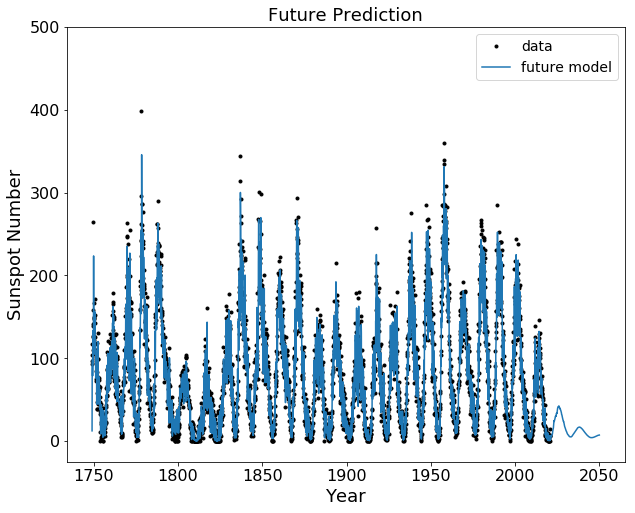

In [109]:
diffyear = 2050 - decyear[-1]
#number of months between the last measurement and 2050
numNewMonths = diffyear*12 
M = model(best_theta, ssn)

# Futute model current model + the empty future data
FX = np.concatenate((M, np.zeros(int(numNewMonths))))

#fill the empty future spots in FX with values from the model
#getting new values based off of previous ones
for i in range(len(M), len(FX)):
    FX[i] = (phi1*FX[i-1]) + (phi2*FX[i-12]) + (phi3*FX[i-132])
    
time = np.linspace(decyear[0], 2050, len(M)+numNewMonths)

figure(figsize=(10,8))
plot(decyear, ssn, 'k.', label = "data")
plot(time, FX, label = "future model")
ylim([-25,500])
title("Future Prediction")
xlabel('Year')
ylabel('Sunspot Number')
legend()
#savefig("FutureFittedSunspot.png")
show()